In [18]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
image_path = "/content/drive/MyDrive/Colab Notebooks/CFL_training_data"

In [20]:
input_images = []
output_images = []
for image in os.listdir(os.path.join(image_path, 'input'))[:1000]:
  input_images.append(cv2.resize(cv2.imread(os.path.join(image_path, 'input', image)), (256,256)))
  output_images.append(cv2.resize(cv2.imread(os.path.join(image_path, 'output_core', image), cv2.IMREAD_GRAYSCALE), (256,256))/255)
output_images = [image[..., np.newaxis] for image in output_images]

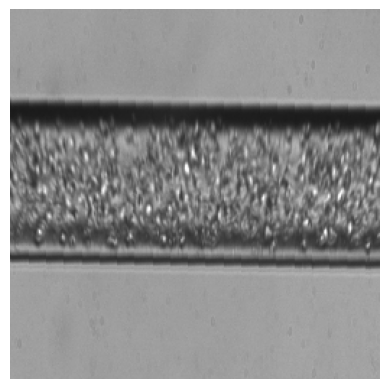

(256, 256, 3)


In [21]:
plt.imshow(input_images[0])
plt.axis('off')
plt.show()
print(input_images[0].shape)

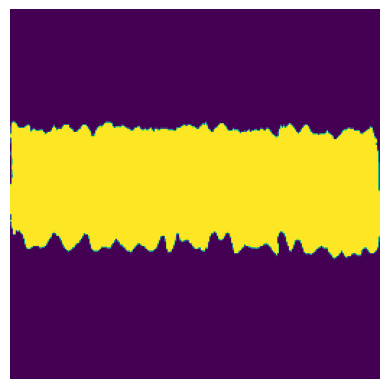

(256, 256, 1)


In [22]:
plt.imshow(output_images[1]*255)
plt.axis('off')
plt.show()
print(output_images[1].shape)

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [24]:
def unet_plus_plus(input_shape=(256, 256, 3), num_filters=64):
    inputs = Input(input_shape)

    # Downsampling
    c1 = conv_block(inputs, num_filters)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv_block(p1, num_filters * 2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv_block(p2, num_filters * 4)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv_block(p3, num_filters * 8)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv_block(p4, num_filters * 16)

    # Upsampling
    u6 = Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv_block(u6, num_filters * 8)

    u7 = Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv_block(u7, num_filters * 4)

    u8 = Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv_block(u8, num_filters * 2)

    u9 = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(0.1)(u9)
    c9 = conv_block(u9, num_filters)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

    #model = Model(inputs=[inputs], outputs=[outputs], name = "U-Net++")
    model = Model(inputs=[inputs], outputs=[outputs], name="U_Net_Plus_Plus")


    return model


In [25]:
model = unet_plus_plus()
model.summary()

Model: "U_Net_Plus_Plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 64)         256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 64)         0         ['batch_normaliz

In [26]:
import keras.backend as K
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return 0.01 * tf.keras.losses.binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.binary_crossentropy, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])
#model.compile(optimizer=Adam(lr=1e-4), loss=dice_p_bce, metrics=['accuracy', dice_coef, mean_iou])

In [28]:
checkpoint_filepath = os.path.join(image_path, "{epoch:02d}-{val_loss:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [41]:
model.fit(x=np.array(input_images),
    y=np.array(output_images),
    validation_split=0.2,
    batch_size=8,
    epochs=40,
    callbacks=[model_checkpoint_callback],
    shuffle=False)

Epoch 1/40
100/100 [==============================] - 79s 792ms/step - loss: 0.0296 - dice_coef: 0.9688 - binary_accuracy: 0.9664 - true_positive_rate: 0.9819 - val_loss: 0.0971 - val_dice_coef: 0.9283 - val_binary_accuracy: 0.9557 - val_true_positive_rate: 0.9842
Epoch 2/40
100/100 [==============================] - 78s 785ms/step - loss: 0.0291 - dice_coef: 0.9694 - binary_accuracy: 0.9665 - true_positive_rate: 0.9820 - val_loss: 0.0727 - val_dice_coef: 0.9537 - val_binary_accuracy: 0.9574 - val_true_positive_rate: 0.9813
Epoch 3/40
100/100 [==============================] - 78s 781ms/step - loss: 0.0285 - dice_coef: 0.9700 - binary_accuracy: 0.9667 - true_positive_rate: 0.9822 - val_loss: 0.0871 - val_dice_coef: 0.9410 - val_binary_accuracy: 0.9562 - val_true_positive_rate: 0.9741
Epoch 4/40
100/100 [==============================] - 78s 779ms/step - loss: 0.0279 - dice_coef: 0.9707 - binary_accuracy: 0.9668 - true_positive_rate: 0.9824 - val_loss: 0.1167 - val_dice_coef: 0.9204 - v

In [42]:
model.save(os.path.join(image_path, 'unet_plus_plus_40_epochs.hdf5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
np.array(input_images[:10]).shape

(10, 256, 256, 3)

In [44]:
# Predicting on the first 10 images
pred = model.predict(np.array(input_images[:10]))

1/1 [==============================] - 0s 33ms/step


In [45]:
# Example for checking the statistics of the first predicted image
print('Min:', np.min(pred[0]))
print('Max:', np.max(pred[0]))
print('Mean:', np.mean(pred[0]))
print('Unique values:', np.unique(pred[0]))

Min: 4.726384e-05
Max: 1.0
Mean: 0.31777367
Unique values: [4.7263838e-05 4.7278896e-05 4.7948030e-05 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


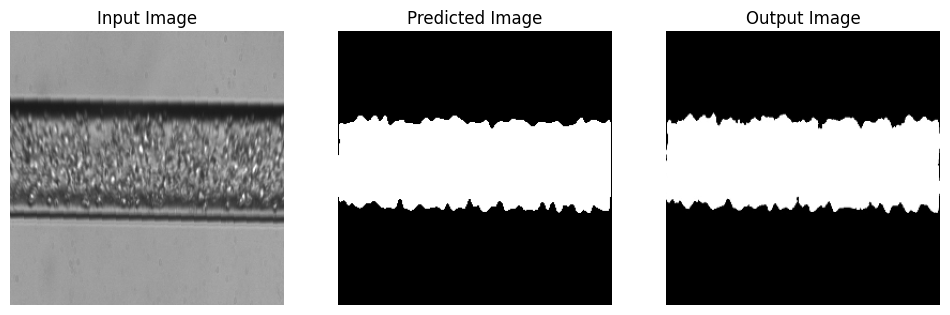

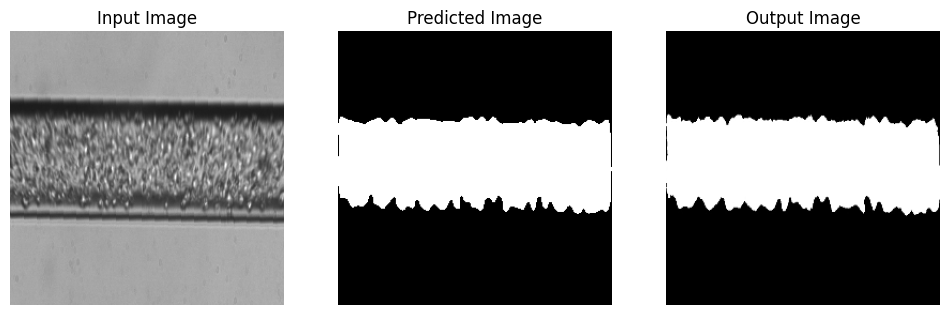

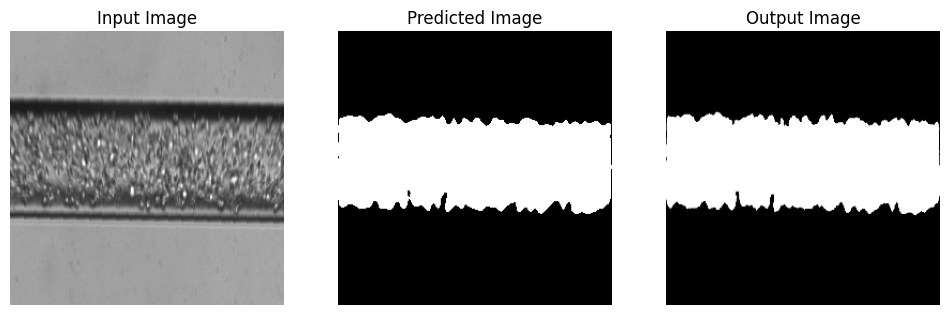

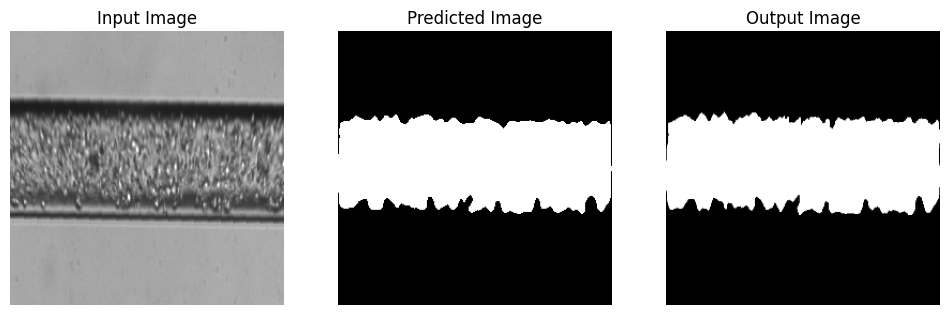

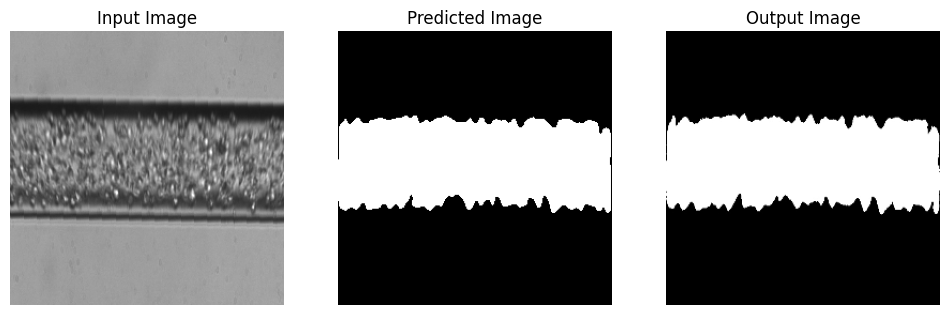

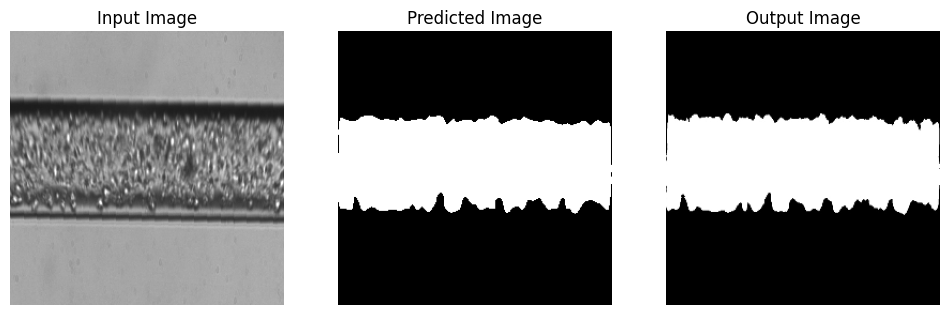

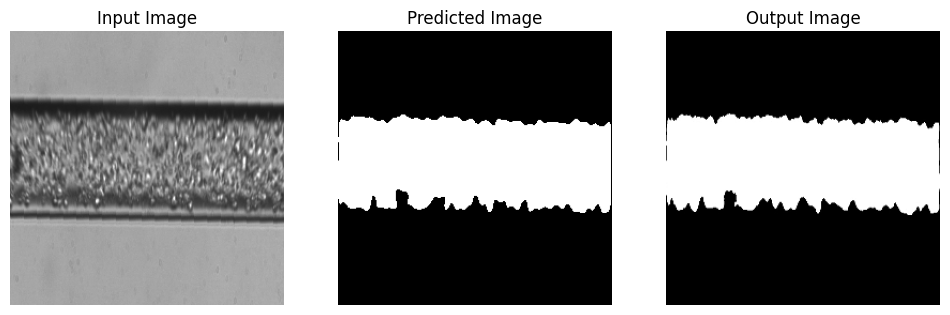

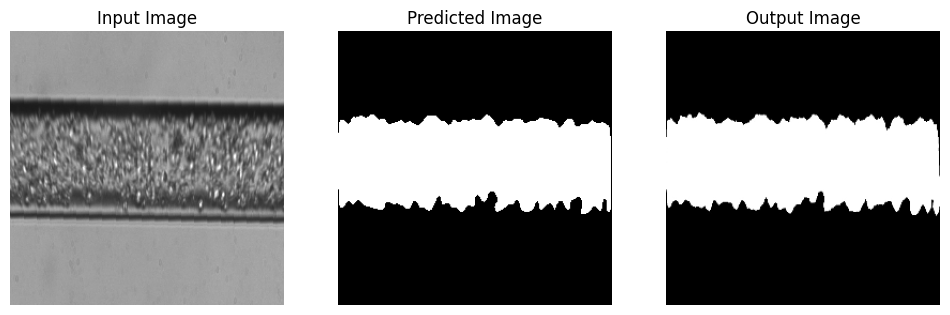

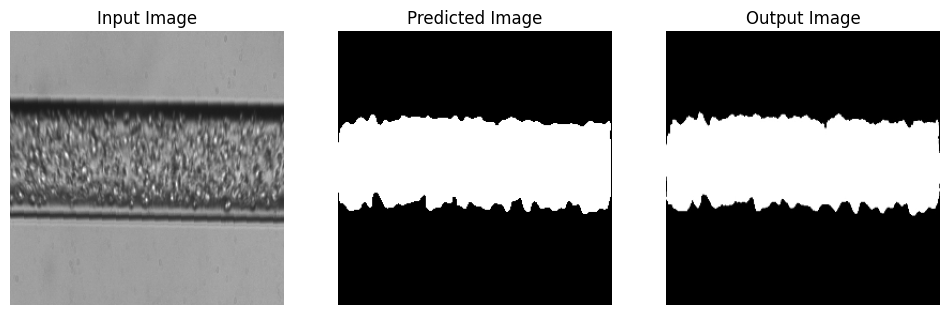

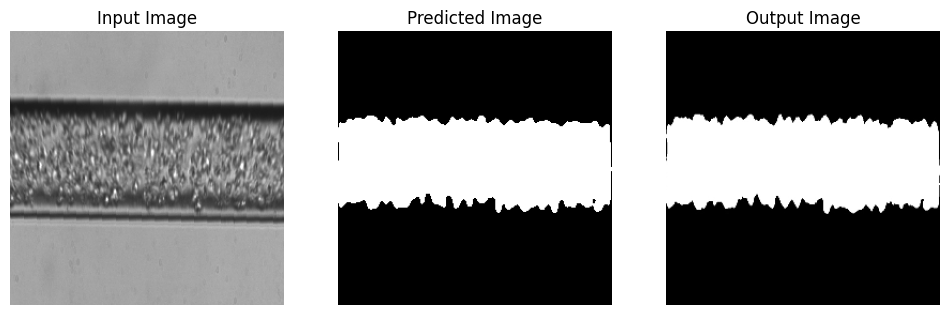

In [47]:
# Plotting the input, predicted, and output images without threshold
for i in range(10):
    plt.figure(figsize=(12, 6))

    # Display input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_images[i])
    plt.title("Input Image")
    plt.axis('off')

    # Display predicted image without threshold
    plt.subplot(1, 3, 2)
    plt.imshow(pred[i]>0.8, cmap='gray', vmin=0, vmax=1)
    plt.title("Predicted Image")
    plt.axis('off')

    # Display corresponding output image
    plt.subplot(1, 3, 3)
    plt.imshow(output_images[i][:, :, 0], cmap='gray', vmin=0, vmax=1)  # Assuming output_images are normalized
    plt.title("Output Image")
    plt.axis('off')

    plt.show()
